In [1]:
from helper_fun import *

pd.options.display.max_colwidth = 300

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Using tensorflow version: 2.5.0-rc2


In [37]:
# Load and shuffle train dataset
train_df = pd.read_csv('nlp_getting_started/train.csv')
train_df = train_df.sample(frac= 1, random_state= 42)   
train_df.reset_index(drop = True, inplace=True)

# Split train dataset into train and validation dataset
train_df, val_df = train_test_split(train_df, test_size = 0.1, random_state= 42)

x_train, y_train = train_df.text.to_numpy(), train_df.target.to_numpy()
x_val, y_val = val_df.text.to_numpy(), val_df.target.to_numpy()


# Load test dataset
test_df = pd.read_csv('nlp_getting_started/test.csv')
x_test, y_test = train_df.text.to_numpy(), x_test.target.to_numpy()

print(f'Train dataset size: {train_df.shape} \nValidation dataset size: {val_df.shape} \nTest dataset size: {test_df.shape}')

Train dataset size: (6851, 5) 
Validation dataset size: (762, 5) 
Test dataset size: (3263, 4)


In [31]:
train_df['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [21]:
train_df[['text']].sample(5)

,text
7164,the war on drugs has turned the U.S. into a WAR zone.
2922,Hundreds feared drowned as migrant boat capsizes off Libya http://t.co/7S1GfNEBgt
6713,OUN cancels Severe Thunderstorm Warning for Lincoln Logan Oklahoma [OK] http://t.co/bTi8JAMFiu #WX
1589,Gulfport Energy - All-In Realizations Fall Off A Cliff http://t.co/CjuiGhBxyn
1217,Bradford. Back to doing what we do best. Burning down our own buildings. Read it and weep Leeds. https://t.co/OLnfzb86zb


In [92]:
# Create text vectorization layer

MAX_TOKENS = 1000
LEN_OUTPUT = 15

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = MAX_TOKENS,
                                                                              standardize = 'lower_and_strip_punctuation',
                                                                              split = 'whitespace',
                                                                              ngrams = 2,
                                                                              output_mode = 'int',
                                                                              output_sequence_length = LEN_OUTPUT,
                                                                              pad_to_max_tokens = True,
                                                                              name = 'text_vectorizer')


# Fit the text vectorizer to train sentences
vectorize_layer.adapt(x_train)

In [112]:
# Creating an embedding layer

embedding = layers.Embedding(input_dim = 1000,
                            output_dim = 128,
                            input_length = 15)


In [117]:
sample = ["there is flood in bengaluru"]
print(f'Original: {sample[0]}')
print(f'Vectorized version: {vectorize_layer(sample).numpy()}')
print(f'ewmbedded version: {embedding(vectorize_layer(sample))}')

Original: there is flood in bengaluru
Vectorized version: [[ 76   9 262   4   1 868   1   1   1   0   0   0   0   0   0]]
ewmbedded version: [[[ 0.02275309 -0.0320123  -0.01677699 ... -0.01873398 -0.01426294
   -0.00757205]
  [ 0.01179193 -0.00436978 -0.02596833 ...  0.02181014  0.02588617
    0.03160607]
  [-0.01564534 -0.00963364 -0.01600089 ... -0.00658482  0.01059706
   -0.04818993]
  ...
  [-0.04114591  0.01486364 -0.02345952 ... -0.03580046 -0.03685781
    0.01977808]
  [-0.04114591  0.01486364 -0.02345952 ... -0.03580046 -0.03685781
    0.01977808]
  [-0.04114591  0.01486364 -0.02345952 ... -0.03580046 -0.03685781
    0.01977808]]]


In [119]:
embedding(vectorize_layer(['there']))

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02275309, -0.0320123 , -0.01677699, ..., -0.01873398,
         -0.01426294, -0.00757205],
        [-0.04114591,  0.01486364, -0.02345952, ..., -0.03580046,
         -0.03685781,  0.01977808],
        [-0.04114591,  0.01486364, -0.02345952, ..., -0.03580046,
         -0.03685781,  0.01977808],
        ...,
        [-0.04114591,  0.01486364, -0.02345952, ..., -0.03580046,
         -0.03685781,  0.01977808],
        [-0.04114591,  0.01486364, -0.02345952, ..., -0.03580046,
         -0.03685781,  0.01977808],
        [-0.04114591,  0.01486364, -0.02345952, ..., -0.03580046,
         -0.03685781,  0.01977808]]], dtype=float32)>

# Modelling experiments to run

* model_0: Naive bayes with tf-idf encoder (baseline model)
* model_1: Feed forward neural network
* model_2: LSTM
* model_3: GRU
* model_4: Bidirectional LSTM
* model_5: 1-D CNN
* model_6: Tensorflow Hub pretrained feature extractor
* model_7: Tensorflow Hub pretrained feature extractor(10% data)

### model_0: Naive bayes with tf-idf encoder (baseline model)

In [149]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.pipeline import Pipeline

In [135]:
# Create tokenizer and model as a pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the model
model_0.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [142]:
baseline_score = model_0.score(x_val, y_val)
print(f"Our baseline model achieves accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves accuracy of 79.27%


In [153]:
precision_recall_fscore_support(y_val,model_0.predict(x_val))

(array([0.74806202, 0.88617886]),
 array([0.93236715, 0.62643678]),
 array([0.83010753, 0.73400673]),
 array([414, 348], dtype=int64))

In [199]:
y_pred =  model_0.predict(x_val)
baseline_model_results = evaluate_model(y_val, y_pred)
baseline_model_results

{'accuracy': 79.27, 'precision': 81.11, 'recall': 79.27, 'f1 score': 78.62}

# model_1: Feed forward neural network

In [161]:
tensorboard_log_dir = 'nlp_models'

In [180]:
# Build model with Functional API
inputs = layers.Input(shape= (1,), dtype= tf.string)

x = vectorize_layer(inputs) # Vectorize the inputs
x = embedding(x) # Create embedding 
x = layers.GlobalAveragePooling1D()(x)  
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name = 'model_1')

model_1.compile(loss = BinaryCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])



In [181]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorizer (TextVectori (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           128000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 128,129
Trainable params: 128,129
Non-trainable params: 0
_________________________________________________________________


In [182]:
history_1 = model_1.fit(x_train, y_train,
                        epochs = 5, 
                        validation_data= (x_val, y_val), 
                        callbacks= [create_tensorboard_callback(dir_name= tensorboard_log_dir, experiment_name='model_1')])

Saving tensorboard log files to nlp_models\model_1\20210527_202904
Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.6029 - accuracy: 0.6979 - val_loss: 0.5560 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 1s 3ms/step - loss: 0.4954 - accuracy: 0.7882 - val_loss: 0.5090 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 3ms/step - loss: 0.4490 - accuracy: 0.8022 - val_loss: 0.5010 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4240 - accuracy: 0.8117 - val_loss: 0.4966 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4088 - accuracy: 0.8158 - val_loss: 0.4977 - val_accuracy: 0.7782


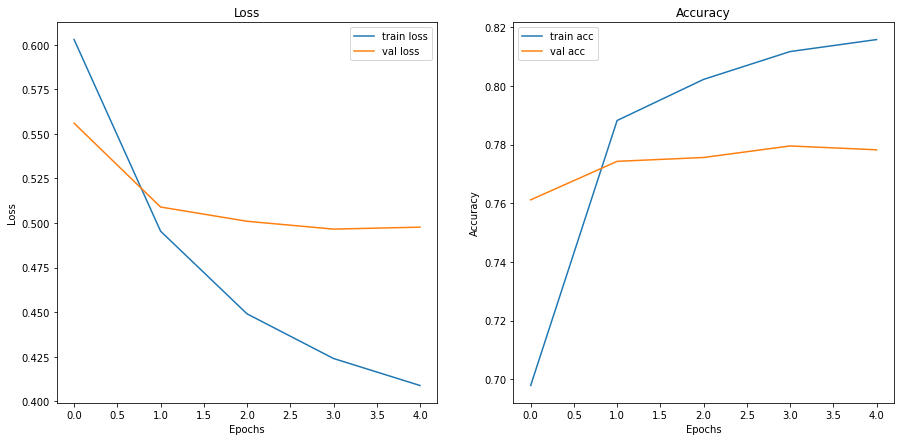

In [183]:
plot_history(history_1)

In [200]:
y_pred = tf.round(tf.squeeze(model_1.predict(x_val)))
model_1_results = evaluate_model(y_val, y_pred)
model_1_results

{'accuracy': 77.82, 'precision': 78.38, 'recall': 77.82, 'f1 score': 77.47}

### Visualize the embedding layer on projector by tensorflow

Below code helps in visualizing the learned embeddings on [Embedding Projector](http://projector.tensorflow.org/)


```
weights = model_1.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()
```

# Recurrent Neural Networks (RNN)

> Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a
sequence, while maintaining an internal state that encodes information about the
timesteps it has seen so far.


There are three built-in RNN layers in Keras:
1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.
2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

The intuition of RNN is that is uses the representation of previous input to determine the next input.

RNN is used for sequence data like text and timeseries data

RNN keras implementation on [GitHub](https://github.com/keras-team/keras-io/blob/master/guides/working_with_rnns.py)

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

# model_2: LSTM(RNN)

LSTM: Long short term memory

In [276]:
inputs = layers.Input(shape= (1,), dtype= tf.string, name= 'input_layer')

x = vectorize_layer(inputs)
x = embedding(x)

# When stacking multiple RNN layers, we need to set return_sequences = True
x = layers.LSTM(units = 64, return_sequences = True, name = 'lstm_layer_1')(x) 
x = layers.LSTM(64,  name = 'lstm_layer_2')(x)
x = layers.Dense(64, activation = 'relu', name = 'dense_layer_1')(x)

outputs = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs, name = 'model_2')

In [274]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorizer (TextVectori (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           128000    
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 15, 64)            49408     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 64)                33024     
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65  

In [277]:
model_2.compile(loss= BinaryCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

history_2 = model_2.fit(x_train, y_train, epochs = 10, validation_data=(x_val, y_val), 
                        callbacks= [create_tensorboard_callback(tensorboard_log_dir, 'model_2')])

Saving tensorboard log files to nlp_models\model_2\20210528_185015
Epoch 1/5
215/215 [==============================] - 11s 39ms/step - loss: 0.3969 - accuracy: 0.8318 - val_loss: 0.5379 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3426 - accuracy: 0.8551 - val_loss: 0.5413 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3227 - accuracy: 0.8612 - val_loss: 0.6172 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3001 - accuracy: 0.8686 - val_loss: 0.6086 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2850 - accuracy: 0.8800 - val_loss: 0.6925 - val_accuracy: 0.7546


In [279]:
y_pred = tf.round(tf.squeeze(model_2.predict(x_val)))
model_2_results = evaluate_model(y_val, y_pred)
model_2_results

{'accuracy': 75.46, 'precision': 75.55, 'recall': 75.46, 'f1 score': 75.26}

In [280]:
baseline_model_results

{'accuracy': 79.27, 'precision': 81.11, 'recall': 79.27, 'f1 score': 78.62}

In [282]:
# Trying to improve model_2 results by increaing the LSTM layers and training for double the epochs

inputs = layers.Input(shape= (1,), dtype= tf.string, name= 'input_layer')

x = vectorize_layer(inputs)
x = embedding(x)

# When stacking multiple RNN layers, we need to set return_sequences = True
x = layers.LSTM(units = 64, return_sequences = True, name = 'lstm_layer_1')(x) 
x = layers.LSTM(units = 64, return_sequences = True, name = 'lstm_layer_2')(x) 
x = layers.LSTM(64,  name = 'lstm_layer_3')(x)
x = layers.Dense(64, activation = 'relu', name = 'dense_layer_1')(x)

outputs = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)

model_2_1 = tf.keras.Model(inputs, outputs, name = 'model_2_1')

model_2_1.summary()

Model: "model_2_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorizer (TextVectori (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           128000    
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, 15, 64)            49408     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 15, 64)            33024     
_________________________________________________________________
lstm_layer_3 (LSTM)          (None, 64)                33024     
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                41

In [283]:
model_2_1.compile(loss= BinaryCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

history_2_1 = model_2_1.fit(x_train, y_train, epochs = 10, validation_data=(x_val, y_val), 
                        callbacks= [create_tensorboard_callback(tensorboard_log_dir, 'model_2_1')])

Saving tensorboard log files to nlp_models\model_2_1\20210528_185417
Epoch 1/10
215/215 [==============================] - 14s 46ms/step - loss: 0.3794 - accuracy: 0.8359 - val_loss: 0.5792 - val_accuracy: 0.7559
Epoch 2/10
215/215 [==============================] - 4s 20ms/step - loss: 0.3037 - accuracy: 0.8680 - val_loss: 0.6628 - val_accuracy: 0.7454
Epoch 3/10
215/215 [==============================] - 4s 20ms/step - loss: 0.2844 - accuracy: 0.8768 - val_loss: 0.7085 - val_accuracy: 0.7454
Epoch 4/10
215/215 [==============================] - 4s 20ms/step - loss: 0.2582 - accuracy: 0.8886 - val_loss: 0.7923 - val_accuracy: 0.7323
Epoch 5/10
215/215 [==============================] - 4s 21ms/step - loss: 0.2414 - accuracy: 0.8921 - val_loss: 0.9498 - val_accuracy: 0.7283
Epoch 6/10
215/215 [==============================] - 4s 20ms/step - loss: 0.2325 - accuracy: 0.8993 - val_loss: 0.8325 - val_accuracy: 0.7244
Epoch 7/10
215/215 [==============================] - 5s 21ms/step - los

In [284]:
y_pred = tf.round(tf.squeeze(model_2_1.predict(x_val)))
model_2_1_results = evaluate_model(y_val, y_pred)
model_2_1_results

{'accuracy': 73.88, 'precision': 73.88, 'recall': 73.88, 'f1 score': 73.72}

# model_3: GRU (Gated Recurrent Unit)


In [304]:
inputs = layers.Input(shape= (1,), dtype= tf.string, name = 'input_layer')

x = vectorize_layer(inputs)
x = embedding(x)

x = layers.GRU(64, return_sequences = True, name = 'GRU_layer_1')(x)
x = layers.GRU(64, name = 'GRU_layer_2')(x)
x = layers.Dense(64, activation = 'relu', name = 'dense_layer_1')(x)

outputs = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3')

model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorizer (TextVectori (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           128000    
_________________________________________________________________
GRU_layer_1 (GRU)            (None, 15, 64)            37248     
_________________________________________________________________
GRU_layer_2 (GRU)            (None, 64)                24960     
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65  

In [305]:
model_3.compile(loss= BinaryCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

history_3 = model_3.fit(x_train, y_train, epochs = 5, validation_data=(x_val, y_val), 
                        callbacks= [create_tensorboard_callback(tensorboard_log_dir, 'model_3')])

Saving tensorboard log files to nlp_models\model_3\20210528_190842
Epoch 1/5
215/215 [==============================] - 11s 37ms/step - loss: 0.3713 - accuracy: 0.8400 - val_loss: 0.6348 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2595 - accuracy: 0.8875 - val_loss: 0.8615 - val_accuracy: 0.7375
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2169 - accuracy: 0.9075 - val_loss: 0.9068 - val_accuracy: 0.7152
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1814 - accuracy: 0.9234 - val_loss: 1.1336 - val_accuracy: 0.7415
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1674 - accuracy: 0.9257 - val_loss: 1.2637 - val_accuracy: 0.7152


In [298]:
y_pred = tf.round(tf.squeeze(model_3.predict(x_val)))
model_3_results = evaluate_model(y_val, y_pred)
model_3_results

{'accuracy': 73.1, 'precision': 73.15, 'recall': 73.1, 'f1 score': 72.86}

# model_4: Bi-directional LSTM

In [315]:
inputs = layers.Input(shape=(1,), dtype= tf.string, name = 'input_layer')

x = vectorize_layer(inputs)
x = embedding(x)

x = layers.Bidirectional(layers.LSTM(8, return_sequences = True, name = 'lstm_layer_1'))(x)
x = layers.Bidirectional(layers.GRU(8, name = 'gru_layer_1'))(x)
x = layers.Dense(16, activation = 'relu', name = 'dense_layer_1')(x)

outputs = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)

model_4 = tf.keras.Model(inputs, outputs, name = 'model_4')

model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorizer (TextVectori (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           128000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 15, 16)            8768      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 16)                1248      
_________________________________________________________________
dense_layer_1 (Dense)        (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17  

In [316]:
model_4.compile(loss= BinaryCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

history_4 = model_4.fit(x_train, y_train, epochs = 5, validation_data=(x_val, y_val), 
                        callbacks= [create_tensorboard_callback(tensorboard_log_dir, 'model_4')])

Saving tensorboard log files to nlp_models\model_4\20210528_210614
Epoch 1/5
215/215 [==============================] - 17s 52ms/step - loss: 0.4625 - accuracy: 0.7872 - val_loss: 0.5172 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3030 - accuracy: 0.8726 - val_loss: 0.6005 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2510 - accuracy: 0.8993 - val_loss: 0.6613 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2178 - accuracy: 0.9156 - val_loss: 0.7418 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.1987 - accuracy: 0.9218 - val_loss: 0.7603 - val_accuracy: 0.7638


In [317]:
y_pred = tf.round(tf.squeeze(model_4.predict(x_val)))
model_4_results = evaluate_model(y_val, y_pred)
model_4_results

{'accuracy': 76.38, 'precision': 76.35, 'recall': 76.38, 'f1 score': 76.3}